In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.graphics.regressionplots import plot_partregress_grid
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("C:/Users/PC/Desktop/ML project/CarPrice_Assignment.csv")
df.dtypes
df .head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [5]:
# Select required columns
cleaned_data = df[['enginesize', 'horsepower', 'carwidth', 'price']]
cleaned_data.to_csv('filtered_data.csv', index=False)

print(cleaned_data.head())

   enginesize  horsepower  carwidth    price
0         130         111      64.1  13495.0
1         130         111      64.1  16500.0
2         152         154      65.5  16500.0
3         109         102      66.2  13950.0
4         136         115      66.4  17450.0


In [7]:
cleaned_data = df[['enginesize', 'horsepower', 'carwidth', 'price']].copy()

cleaned_data['log_price'] = np.log(cleaned_data['price'] + 1)  # Add 1 to avoid log(0)
y = cleaned_data['log_price']
xvars = ['enginesize', 'horsepower', 'carwidth']
X = cleaned_data[xvars]

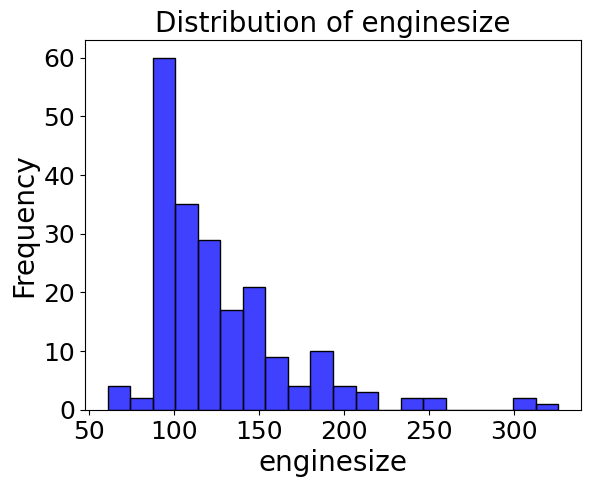

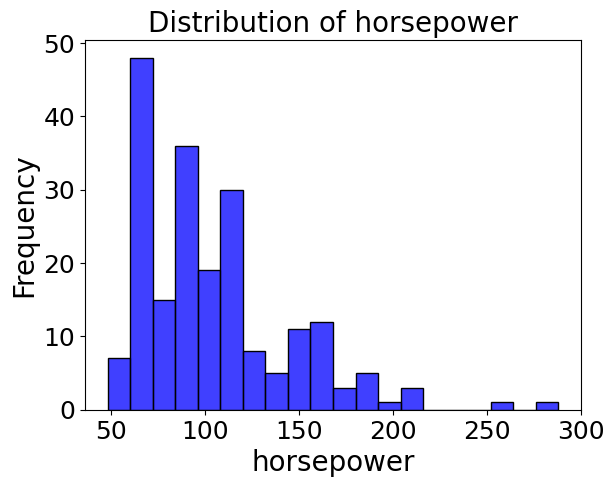

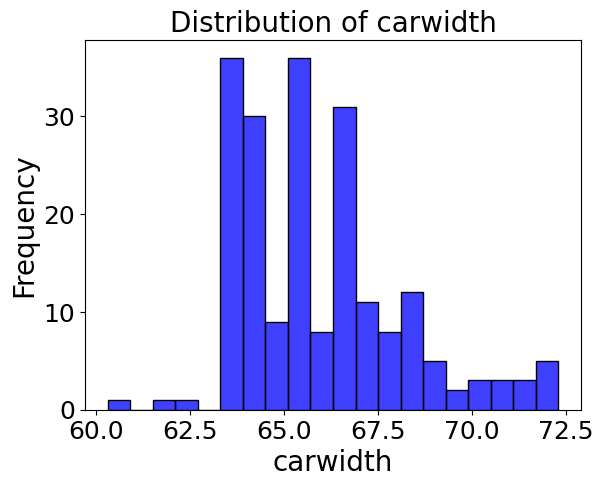

In [9]:
for i in xvars:
    sns.histplot(data=df, x=i, bins=20, kde=False, color='blue')
    plt.xlabel(i, fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(f'Distribution of {i}', fontsize=20)
    plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mlr_model = LinearRegression()
mlr_model.fit(X_train, y_train)

# Make predictions (log scale)
y_pred_train = mlr_model.predict(X_train)  # training set
y_pred_test = mlr_model.predict(X_test)   # testing set

# Reverse log transformation to original scale
y_train_original = np.exp(y_train) - 1
y_test_original = np.exp(y_test) - 1
y_pred_train_original = np.exp(y_pred_train) - 1
y_pred_test_original = np.exp(y_pred_test) - 1

# Train set (original scale)
train_r2_original = r2_score(y_train_original, y_pred_train_original)
train_mse_original = mean_squared_error(y_train_original, y_pred_train_original)
train_rmse_original = np.sqrt(train_mse_original)
print("Train R² (original scale):", train_r2_original)
print("Train MSE (original scale):", train_mse_original)
print("Train RMSE (original scale):", train_rmse_original)

# Test set (original scale)
test_r2_original = r2_score(y_test_original, y_pred_test_original)
test_mse_original = mean_squared_error(y_test_original, y_pred_test_original)
test_rmse_original = np.sqrt(test_mse_original)
print("Test R² (original scale):", test_r2_original)
print("Test MSE (original scale):", test_mse_original)
print("Test RMSE (original scale):", test_rmse_original)

Train R² (original scale): 0.625721218890559
Train MSE (original scale): 22321177.084837135
Train RMSE (original scale): 4724.529297701215
Test R² (original scale): 0.8316522661134108
Test MSE (original scale): 13290047.018985957
Test RMSE (original scale): 3645.551675533616


In [12]:
cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

# Detect and handle outliers using IQR
Q1 = cleaned_data.quantile(0.25)  # First quartile
Q3 = cleaned_data.quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN for inspection
outlier_mask = (cleaned_data < lower_bound) | (cleaned_data > upper_bound)
cleaned_data_outlier_replaced = cleaned_data.where(~outlier_mask, np.nan)

# Option 1: Remove rows with outliers
cleaned_data_no_outliers = cleaned_data[~outlier_mask.any(axis=1)]

# Option 2: Replace outliers with median
cleaned_data_filled_outliers = cleaned_data_outlier_replaced.fillna(cleaned_data.median())

# Save the processed dataset
cleaned_data_no_outliers.to_csv('cleaned_data_no_outliers.csv', index=False)
cleaned_data_filled_outliers.to_csv('cleaned_data_filled_outliers.csv', index=False)

# Check data after processing
print("Data after removing outliers:")
print(cleaned_data_no_outliers.describe(include=['int64', 'float64']).round(2))

Data after removing outliers:
       enginesize  horsepower  carwidth     price  log_price
count      186.00      186.00    186.00    186.00     186.00
mean       117.82       96.31     65.53  11325.71       9.25
std         26.67       29.39      1.70   4846.80       0.40
min         61.00       48.00     60.30   5118.00       8.54
25%         97.00       70.00     64.00   7629.00       8.94
50%        110.00       91.00     65.40   9767.00       9.19
75%        135.50      114.00     66.50  14466.50       9.58
max        183.00      175.00     70.30  28248.00      10.25


In [19]:
import pandas as pd
import numpy as np
!pip install xgboost
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from scipy.stats import boxcox

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [20]:
df = pd.read_csv("C:/Users/PC/Desktop/ML project/CarPrice_Assignment.csv")
df.head
import pandas as pd

# Load the dataset

# Select the required columns
cleaned_data = df[['enginesize', 'horsepower', 'carwidth','price']]

# Save the filtered dataframe to a new CSV file if needed
cleaned_data.to_csv('filtered_data.csv', index=False)

print(cleaned_data.head())  # Display the first few rows of the filtered data

   enginesize  horsepower  carwidth    price
0         130         111      64.1  13495.0
1         130         111      64.1  16500.0
2         152         154      65.5  16500.0
3         109         102      66.2  13950.0
4         136         115      66.4  17450.0


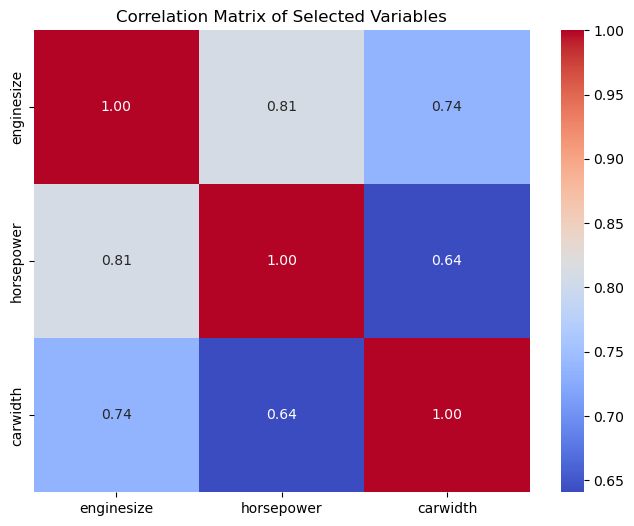

In [21]:
selected_variables = ['enginesize', 'horsepower', 'carwidth']
df_selected = cleaned_data[selected_variables]

correlation_matrix = df_selected.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Variables")
plt.show()

In [22]:
print(cleaned_data.shape)
print(f"No of samples present in data are {df.shape[0]}")
print(f"No of features present in data are {df.shape[1]}")

(205, 4)
No of samples present in data are 205
No of features present in data are 26


In [27]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   enginesize  205 non-null    int64  
 1   horsepower  205 non-null    int64  
 2   carwidth    205 non-null    float64
 3   price       205 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 6.5 KB


In [29]:
cleaned_data.describe(include=['int64', 'float64']).round(2)

,enginesize,horsepower,carwidth,price
count,205.00,205.00,205.00,205.00
mean,126.91,104.12,65.91,13276.71
std,41.64,39.54,2.15,7988.85
min,61.00,48.00,60.30,5118.00
25%,97.00,70.00,64.10,7788.00
50%,120.00,95.00,65.50,10295.00
75%,141.00,116.00,66.90,16503.00
max,326.00,288.00,72.30,45400.00


In [31]:
cleaned_data.isnull().sum().to_frame().rename(columns={0: 'Total No. of Missing Values'})

,Total No. of Missing Values
enginesize,0
horsepower,0
carwidth,0
price,0


In [33]:
cleaned_data.select_dtypes(include='object').head()

""
0
1
2
3
4


In [35]:
cleaned_data.select_dtypes(include=['int64', 'float64']).head()

,enginesize,horsepower,carwidth,price
0,130,111,64.1,13495.0
1,130,111,64.1,16500.0
2,152,154,65.5,16500.0
3,109,102,66.2,13950.0
4,136,115,66.4,17450.0


In [37]:
cleaned_data['CompanyName'] = df['CarName'].apply(lambda x: x.split(" ")[0])

In [39]:
cleaned_data['CompanyName'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [41]:
cleaned_data = cleaned_data.apply(pd.to_numeric, errors='coerce')

# Detect and handle outliers using IQR
Q1 = cleaned_data.quantile(0.25)  # First quartile
Q3 = cleaned_data.quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN for inspection
outlier_mask = (cleaned_data < lower_bound) | (cleaned_data > upper_bound)
cleaned_data_outlier_replaced = cleaned_data.where(~outlier_mask, np.nan)

# Option 1: Remove rows with outliers
cleaned_data_no_outliers = cleaned_data[~outlier_mask.any(axis=1)]

# Option 2: Replace outliers with median
cleaned_data_filled_outliers = cleaned_data_outlier_replaced.fillna(cleaned_data.median())

# Save the processed dataset
cleaned_data_no_outliers.to_csv('cleaned_data_no_outliers.csv', index=False)
cleaned_data_filled_outliers.to_csv('cleaned_data_filled_outliers.csv', index=False)

# Check data after processing
print("Data after removing outliers:")
print(cleaned_data_no_outliers.describe(include=['int64', 'float64']).round(2))

Data after removing outliers:
       enginesize  horsepower  carwidth     price  CompanyName
count      186.00      186.00    186.00    186.00          0.0
mean       117.82       96.31     65.53  11325.71          NaN
std         26.67       29.39      1.70   4846.80          NaN
min         61.00       48.00     60.30   5118.00          NaN
25%         97.00       70.00     64.00   7629.00          NaN
50%        110.00       91.00     65.40   9767.00          NaN
75%        135.50      114.00     66.50  14466.50          NaN
max        183.00      175.00     70.30  28248.00          NaN


In [43]:
cleaned_data_no_outliers["price"].agg(["min","mean","median","max","std","skew"]).to_frame().T.round(2)

,min,mean,median,max,std,skew
price,5118.0,11325.71,9767.0,28248.0,4846.8,1.09


In [45]:
np.log(df["price"] + 1).agg(["min","mean","median","max","std","skew"]).to_frame().T.round(2)

,min,mean,median,max,std,skew
price,8.54,9.35,9.24,10.72,0.5,0.67


In [47]:
new_df = cleaned_data_no_outliers
new_df.head()

,enginesize,horsepower,carwidth,price,CompanyName
0,130,111,64.1,13495.0,NaN
1,130,111,64.1,16500.0,NaN
2,152,154,65.5,16500.0,NaN
3,109,102,66.2,13950.0,NaN
4,136,115,66.4,17450.0,NaN


In [49]:
y = new_df[['price']]
x = new_df.drop(columns=['price'])

x = pd.get_dummies(x,columns=x.select_dtypes(include=['object','category']).columns, drop_first=True, dtype='int64')

x.head()

,enginesize,horsepower,carwidth,CompanyName
0,130,111,64.1,NaN
1,130,111,64.1,NaN
2,152,154,65.5,NaN
3,109,102,66.2,NaN
4,136,115,66.4,NaN


In [51]:
y_boxcox, lamda = boxcox(y['price']+1)

log_transformer = FunctionTransformer(np.log1p, validate=True, inverse_func=np.expm1)
y_log = log_transformer.transform(y)

y_log[0:5]

array([[9.51014862],
       [9.71117626],
       [9.71117626],
       [9.54330647],
       [9.76715223]])

In [53]:
scale = StandardScaler()
x_sc = scale.fit_transform(x)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, random_state=42, test_size=0.2)

# Print the shape of the splits
print(f"Train features shape: {x_train.shape}")
print(f"Test features shape: {x_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train features shape: (148, 4)
Test features shape: (38, 4)
Train labels shape: (148, 1)
Test labels shape: (38, 1)


In [57]:
x_train_sc = scale.fit_transform(x_train)
x_test_sc = scale.fit_transform(x_test)

In [59]:
def error_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    errors = {}
    
    # Errors for train data
    errors["Train_MAE"] = mean_absolute_error(y_train_true, y_train_pred)
    errors["Train_MSE"] = mean_squared_error(y_train_true, y_train_pred)
    errors["Train_RMSE"] = np.sqrt(errors["Train_MSE"])
    errors["Train_R2_Score"] = r2_score(y_train_true, y_train_pred)
    
    # Errors for test data
    errors["Test_MAE"] = mean_absolute_error(y_test_true, y_test_pred)
    errors["Test_MSE"] = mean_squared_error(y_test_true, y_test_pred)
    errors["Test_RMSE"] = np.sqrt(errors["Test_MSE"])
    errors["Test_R2_Score"] = r2_score(y_test_true, y_test_pred)
    
    return errors

model_evaluation = []

In [61]:
random_forest = RandomForestRegressor(random_state=42, n_estimators=100, criterion='squared_error', max_depth=6)

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
#     'max_depth': np.arange(1,20),
#     'min_samples_split': np.arange(1,10)
# }

# grid_search = GridSearchCV(random_forest, param_grid, cv=5)
random_forest.fit(x_train, y_train)

# Get the best model
# best_forest = grid_search.best_estimator_
# print(best_forest)

RandomForestRegressor(max_depth=6, random_state=42)

In [63]:
y_train_pred = random_forest.predict(x_train)
y_test_pred = random_forest.predict(x_test)

error_random_forest = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_random_forest['Model Name'] = 'Random Forest'
error_random_forest

{'Train_MAE': 900.9215458881922,
 'Train_MSE': 1466351.5587936155,
 'Train_RMSE': 1210.9300387692163,
 'Train_R2_Score': 0.9407083902187634,
 'Test_MAE': 1092.6052612336105,
 'Test_MSE': 2054883.2641013092,
 'Test_RMSE': 1433.4864017845823,
 'Test_R2_Score': 0.8778276019976,
 'Model Name': 'Random Forest'}